# BINF GU 4002: Machine Learning for Healthcare, Spring 2025
# Assignment \#2: Regularization and Model Selection
## DUE: 11:59 PM, Tuesday, March 11, 2025

This assignment explores regularization and model selection. We will use ideas explored in class and build intuition around how to select appropriate modelling techniques for the specific data and task you have. As an illustrative example, you will be using embeddings generated from a large-scale protein language model to predict the structural effects of a mutation in the protein sequence.

**<font color="red">Instructions: Please run the notebook using Google Colab to prevent any dependency / package issues. Make sure that your written answers are formatted using </font>$\LaTeX$<font color="red"> in `markdown` cells. When submitting, please name your files `{UNI}_binf4002_mlhc_assignment_2.{filetype}` and submit a `.ipynb` version of your Jupyter notebook. Additionally, we will render the jupyter notebook using nbviewer (https://nbviewer.org/). When you are submitting your final version, upload your homework to a public github repository and paste the github link to nbviewer and obtain the final rendered link </font>**

Link to github repository:

Link to nbviewer render:

#### The Problem and Data

We will be using data from the [Envision](https://pmc.ncbi.nlm.nih.gov/articles/pmid/29226803/) paper (Gray et al.2018). The goal is to perform variant effect prediction, where variants of β-Lactamase are created by through single-residue mutations (one amino-acid is replaced by another amino-acid in the protein sequence). The data is generated using a method called deep mutational scan.

From Gray et al. 2018:

> In a deep mutational scan, selection for protein function among a library of nearly all possible single amino acid variants of a protein is coupled to high-throughput DNA sequencing (Fowler and Fields, 2014; Fowler et al., 2014). Sequencing reveals how each variant’s frequency changes during selection, yielding quantitative scores that describe the functional effect of each variant in the library. A large-scale mutagenesis dataset contains deep and unbiased information, capturing the effects of most variants at every position in a single protein. We hypothesize that large-scale mutagenesis datasets contain informative and generalizable patterns that can be used to predict variant effects in disparate proteins.

The prediction target is a quantitative metric known as variant effect score, which depends on the protein of interest. For example, this score may capture the severity of functional disruption.

The embeddings are generated from [ESM](https://www.nature.com/articles/s41588-023-01465-0), a large-scale language (foundation) model for protein sequences developed by Meta AI. The repository can be found here: https://github.com/facebookresearch/esm/tree/main  

In [16]:
# STARTER CODE
!pip install git+https://github.com/facebookresearch/esm.git
!curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593_reprs.tar.gz
!tar -xzf P62593_reprs.tar.gz
!curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593.fasta
!pwd
!ls

FASTA_PATH = "/content/P62593.fasta" # Path to P62593.fasta
EMB_PATH = "/content/P62593_reprs" # Path to directory of embeddings for P62593.fasta
EMB_LAYER = 34

  Cloning https://github.com/facebookresearch/esm.git to /tmp/pip-req-build-jsx4e3ka
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/esm.git /tmp/pip-req-build-jsx4e3ka
  Resolved https://github.com/facebookresearch/esm.git to commit 2b369911bb5b4b0dda914521b9475cad1656b2ac
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.5M  100 24.5M    0     0  26.2M      0 --:--:-- --:--:-- --:--:-- 26.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1719k  100 1719k    0     0  4730k      0 --:--:-- --:--:-- --:--:-- 4737k
/content
P62593.fasta  P62593_reprs  P62593_reprs.tar.gz  sample_data


In [17]:
import random
from collections import Counter
from tqdm import tqdm

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import scipy
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA

import esm

ys = []
Xs = []

for header, _seq in esm.data.read_fasta(FASTA_PATH):
    scaled_effect = header.split('|')[-1]
    ys.append(float(scaled_effect))
    fn = f'{EMB_PATH}/{header}.pt'
    embs = torch.load(fn)
    Xs.append(embs['mean_representations'][EMB_LAYER])

Xs = torch.stack(Xs, dim=0).numpy()

train_size = 0.8
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, train_size=train_size, random_state=42)

print(Xs.shape)

<ipython-input-17-e907ffff8eb5>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embs = torch.load(fn)


(5397, 1280)


#### Data exploration

Note that the embeddings are high-dimensional. To qualitatively analyse if there are patterns (ex. naturally-forming clusters) in the data, we can visualize the data using dimensionality reduction. The color indicates the level of functional distruption in the protein, and each point represents a different amino-acid sequence containing a specific mutation.

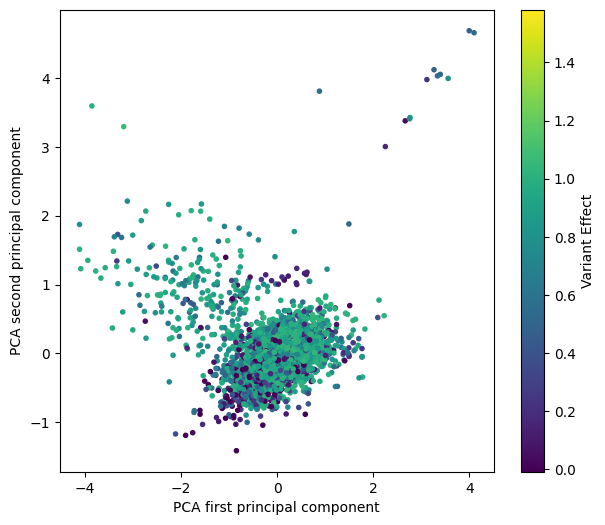

In [18]:
num_pca_components = 60
pca = PCA(num_pca_components)
Xs_train_pca = pca.fit_transform(Xs_train)

fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=ys_train, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Variant Effect')
plt.show()

## [30 Points] Question 1: Bias Variance Tradeoff

Modeling data in healthcare is often in a data-constrained setting, where we may be restricted to high dimensional data with limited samples due to costs of experimentation and data acquisition. However, a key desiderata for our models is the ability to generalize to unseen samples.

How do we know if we have enough data for a given modelling task to achieve generalization? How do we choose the right modeling strategy? We will explore these questions using a phenomenon in machine learning known as the bias-variance tradeoff.

Consider a dataset $$D = \{(x_1, y_1), (x_2, y_2), ..., (x_n, y_n) \}$$

and suppose that the relationship between $x \in \mathbb{R}^1$ and $y \in \mathbb{R}^1$ values are specified by an unknown true underlying function as $y = f(x) + \epsilon$ where $\epsilon \sim N(0, \sigma^2)$.

Now, suppose we have trained an approximation of the underlying true function using the training dataset with $\hat{y} = \hat{f}(x)$, where $\hat{y}$ corresponds to the prediction of $y$

#### [15 Points] 1.1: Prove the bias-variance decomposition of mean squared error
$$\mathbb{E}_{D} \left[(y - \hat{f}(x) )^2\right] = \underbrace{\left(\mathbb{E}\left[\hat{f}(x) \right] - f(x) \right)^2}_{Bias^2} + \underbrace{\mathbb{E}_{D}\left[\left(\hat{f}(x) - \mathbb{E}\left[\hat{f}(x)\right] \right)^2 \right]}_{Variance}$$


#### [5 Points] 1.2: What does it mean for the prediction model $\hat{f}(x)$ to have high bias? What are potential causes of high bias?


#### [5 Points] 1.3: What does it mean for the model to have high variance? What are potential causes of high variance?

#### [5 Points] 1.4 Can bias and variance decrease at the same time?


## **Question 1.1 Answer**
#### 1.1 Prove the bias-variance decomposition of mean squared error

By definition, expected mean squared error (MSE) is:

$$
\mathbb{E}_{D} \left[(y - \hat{f}(x) )^2\right]
$$

where:
- $ y = f(x) + \epsilon $
- $ \hat{f}(x) $ is the learned function of the dataset
- $ \mathbb{E}_D $ denotes expectation in different training datasets

After expand the squared error:

$$
\mathbb{E}_{D} \left[(y - \hat{f}(x) )^2\right] = \mathbb{E}_{D} \left[(f(x) + \epsilon - \hat{f}(x))^2\right]
$$

After expand the squared difference:

$$
(f(x) + \epsilon - \hat{f}(x))^2 = (f(x) - \hat{f}(x) + \epsilon)^2
$$

$$
= (f(x) - \hat{f}(x))^2 + 2\epsilon (f(x) - \hat{f}(x)) + \epsilon^2
$$

$$
\mathbb{E}_{D} \left[(y - \hat{f}(x) )^2\right] = \mathbb{E}_{D} \left[(f(x) - \hat{f}(x))^2\right] + 2 \mathbb{E}_D \left[\epsilon (f(x) - \hat{f}(x))\right] + \mathbb{E}_D \left[\epsilon^2\right]
$$


$ \epsilon $ has zero mean ($ \mathbb{E}[\epsilon] = 0 $) and is independent of $ \hat{f}(x) $:

$$
\mathbb{E}_D [\epsilon (f(x) - \hat{f}(x))] = 0
$$

$$
\mathbb{E}_D [\epsilon^2] = \sigma^2
$$

Simplify:

$$
\mathbb{E}_{D} \left[(y - \hat{f}(x) )^2\right] = \mathbb{E}_{D} \left[(f(x) - \hat{f}(x))^2\right] + \sigma^2
$$

After expanding the first term:

$$
\mathbb{E}_{D} \left[(f(x) - \hat{f}(x))^2\right]
$$

Add and subtract $ \mathbb{E}[\hat{f}(x)] $:

$$
\mathbb{E}_{D} \left[(f(x) - \mathbb{E}[\hat{f}(x)] + \mathbb{E}[\hat{f}(x)] - \hat{f}(x))^2\right]
$$

$$
= \mathbb{E}_{D} \left[ (f(x) - \mathbb{E}[\hat{f}(x)])^2 + 2 (f(x) - \mathbb{E}[\hat{f}(x)])(\mathbb{E}[\hat{f}(x)] - \hat{f}(x)) + (\mathbb{E}[\hat{f}(x)] - \hat{f}(x))^2 \right]
$$


 since $ \mathbb{E}_D [\mathbb{E}[\hat{f}(x)] - \hat{f}(x)] = 0 $.

Thus:

$$
\mathbb{E}_{D} \left[(y - \hat{f}(x) )^2\right] = \underbrace{\left(\mathbb{E}\left[\hat{f}(x) \right] - f(x) \right)^2}_{\text{Bias}^2} + \underbrace{\mathbb{E}_{D}\left[\left(\hat{f}(x) - \mathbb{E}\left[\hat{f}(x)\right] \right)^2 \right]}_{\text{Variance}} + \underbrace{\sigma^2}_{\text{Irreducible Error}}
$$

##**Question 1.2 Answer**

1.2: What does it mean for the prediction model $\hat{f}(x)$ to have high bias? What are potential causes of high bias?

If a prediction model have high bias, it means that this model makes systematic erroes by making over simplistc assumptions on the data. With high bias, this model might not be able to capture the pattern of the data comprehensively, leading to underfiiting problem. With high bias, the prediction model makes incorrect predictions and poor performance on both the training and test data. Additionally, the prediction model fails to capture the truth of the tru function f(x).

Potential causes of high bias might include the following:

1. Missing important variables that are important to make the prediction. For example, it is vital to know a patient's age when predicting their likelihood of getting diabete mellitus.
2. Use over simple model: For example, we cannot use a linear model when the data is not linear
3. Using incorrect assumptions about the data: For example, it might cause bias if we assume the distribution and our assumption is wrong.
4. Using a classifer that lacks complexity. For example, a decision tree might not capture everything but a random forest (teh ensemble learning for decision tree) might be helpful.

# **Question 1.3 Answer**
#### 1.3: What does it mean for the model to have high variance? What are potential causes of high variance?

A model with high variance is sensitive overly to fluctuations in the training data, causing it not learning the pattern but memorize noise. Additionally, The model makes inconsistent predictions when being trained on different datasets. Last but not least, having high variance leads to overfitting, meaning that the model performs poorly on the test data although perform with high accuracy on the training data.

Potential causes of high variance:
1. Insufficient training data: the model might overfit if it was trained on a small dataset that is not big enough.
2. Too many features: If the number of features is too much larger than the number of the training samples, it might lead to overfitting as the model memorizes instead of learning.
3. Overly complaex model: If we use a model that is too complex and flexibile, it might fit the training data well but fail to fit the test data due to its high variance.
variations.

##**Question 1.4 Answer**
#### [5 Points] 1.4 Can bias and variance decrease at the same time?
No. Usually, bias and variance cannot decrease at the same time due to bias-variance trade-off which implies the increase of one decreases the other. Specifically, reducing biases will make the model more complex, leading to increased variance. Reducing variances will make the model more simplified, leading to increased biases.


# [30 Points] Question 2: Regularization

A model with high bias is also called "underfitting", while a model with high variance is also called "overfitting". One idea from the bias-variance tradeoff is that purposefully introducing bias may be an effective strategy in mitigating overfitting and reducing variance.

We will now explore regularization, a common strategy used to introduce bias in the model to improve generalization.

Consider a dataset $$D = \{(\textbf{x}_1, y_1), (\textbf{x}_2, y_2), ..., (\textbf{x}_n, y_n) \}$$

where now each sample contains a vector of $d$ features $\textbf{x}_i \in \mathbb{R}^{d \times 1}$

Suppose we specifiy our model to be a linear regression model. That is, we consider a model with a vector of parameters $\beta \in \mathbb{R}^{d \times 1}$ such that $y_i = \textbf{x}_i^T \beta + \epsilon $

Note that we can equivalently write the set of $n$ equations stacked together using a matrix $\textbf{X} \in \mathbb{R}^{n \times d}$ and $\textbf{y} \in \mathbb{R}^{n \times 1}$ as follows:

$$\textbf{y} = \textbf{X} \beta + \epsilon \text{ , } \quad \epsilon \sim N(0, \sigma^2 I)$$

#### [10 Points] Question 2.1: Derive the optimal solution to the L2-regularized Squared Error Loss (also known as ridge regression) given by

$$(\textbf{X}\beta - \textbf{y})^T(\textbf{X}\beta - \textbf{y}) + \lambda \beta^T\beta $$


#### [15 Points] Question 2.2: Build a Ridge Regression with the skeleton code below (Fill in TODOs).

#### [5 Points] Question 2.3: What do you notice in the relationship between MSE and variance as we increase the lambda parameter?



## **Question 2.1 Answer**
#### 2.1 Derive the optimal solution to the L2-regularized Squared Error Loss

optimal solution = minimize the Ridge Regression objective function

$$
J(\beta) = (\textbf{X}\beta - \textbf{y})^T(\textbf{X}\beta - \textbf{y}) + \lambda \beta^T\beta
$$

Expand:
$$
(\textbf{X}\beta - \textbf{y})^T(\textbf{X}\beta - \textbf{y})
$$

$$
= \beta^T \textbf{X}^T \textbf{X} \beta - 2\textbf{y}^T \textbf{X} \beta + \textbf{y}^T \textbf{y}
$$

$$
J(\beta) = \beta^T \textbf{X}^T \textbf{X} \beta - 2\textbf{y}^T \textbf{X} \beta + \textbf{y}^T \textbf{y} + \lambda \beta^T \beta
$$


Take the derivative of $J(\beta)$ with respect to $( \beta)$:

$$
\nabla_\beta J(\beta) = 2\textbf{X}^T \textbf{X} \beta - 2\textbf{X}^T \textbf{y} + 2\lambda \beta
$$

set the gradient = 0

$$
2\textbf{X}^T \textbf{X} \beta - 2\textbf{X}^T \textbf{y} + 2\lambda \beta = 0
$$

$$
\textbf{X}^T \textbf{X} \beta + \lambda \beta = \textbf{X}^T \textbf{y}
$$


$$
(\textbf{X}^T \textbf{X} + \lambda \textbf{I}) \beta = \textbf{X}^T \textbf{y}
$$

$$
\beta^* = (\textbf{X}^T \textbf{X} + \lambda \textbf{I})^{-1} \textbf{X}^T \textbf{y}
$$

In [19]:
class RidgeRegression:
    def __init__(self, lambda_reg=1.0):
        self.lambda_reg = lambda_reg  # Regularization parameter
        self.beta = None  # Coefficients

    def fit(self, X, y):
        """ Compute the closed-form solution for Ridge Regression. """
        n, d = X.shape
        I = np.eye(d)  # Identity matrix
        XTX = X.T @ X  # Compute X^T X
        XTy = X.T @ y  # Compute X^T y

        # Closed-form solution
        self.beta = np.linalg.inv(XTX + self.lambda_reg * I) @ XTy # TODO: Fill in

    def predict(self, X):
        """ Predict using the learned weights. """
        return X @ self.beta

    def mse(self, y_true, y_pred):
        """ Compute Mean Squared Error (MSE). """
        return np.mean((y_true - y_pred) ** 2) # TODO: Compute MSE

In [20]:
# Define a range of lambda values
lambdas = np.logspace(-3, 3, 30)  # From 0.001 to 1000
mse_values = []
variance_values = []

# Compute bias and variance for each lambda
for lambda_reg in lambdas:
    model = RidgeRegression(lambda_reg)
    model.fit(Xs_train, ys_train)

    predictions = model.predict(Xs_test)
    mse = np.mean((ys_test - predictions) ** 2)
    variance = np.var(predictions)

    mse_values.append(mse)
    variance_values.append(variance)

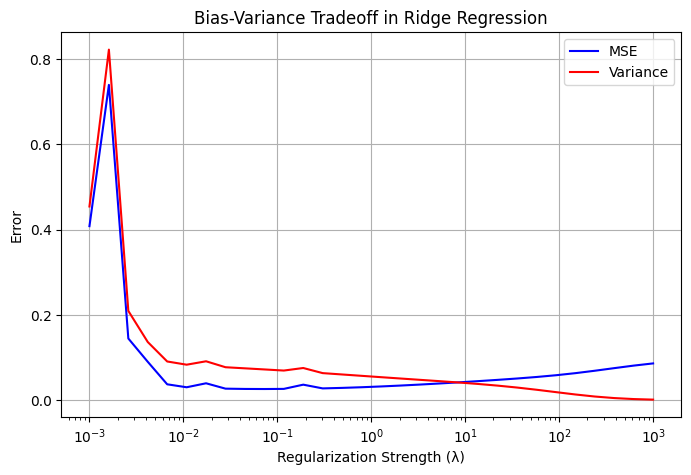

In [21]:
# Plotting Code for question 2.3

plt.figure(figsize=(8, 5))
plt.plot(lambdas, mse_values, label="MSE", color='blue')
plt.plot(lambdas, variance_values, label="Variance", color='red')
plt.xscale('log')  # Log scale for better visualization
plt.xlabel("Regularization Strength (λ)")
plt.ylabel("Error")
plt.title("Bias-Variance Tradeoff in Ridge Regression")
plt.legend()
plt.grid()
plt.show()

##**Question 2.3 Answer**
#### 2.3 What do you notice in the relationship between MSE and variance as we increase the lambda parameter?

 Both MSE and vairiance increase first as there is little regularization. They then both decrease quickly as overfitting is decreasing. When $\lambda$ becomes too large, the model will underfit, thus leading to very small variance but incresaeing MSE.

# [20 Points] Question 3: Bayesian Variable Selection

Follwing the intuition we have built around regularization, we will now explore a more complex Bayesian model for the protein variant effect prediction task. We assume the same linear model with the same dimensionality as before

$$\textbf{y} = \textbf{X} \beta + \epsilon \text{ , } \quad \epsilon \sim N(0, \sigma^2 I)$$

However, now we will introduce a prior on the model parameters $\beta$. For each $\beta_j$ where $j=1, ..., d$, the prior takes the following form

$$ \beta_j | \gamma_j \sim (1 - \gamma_j)\cdot 0 + \gamma_j N(0, \sigma_\beta^2) \text{ , } \quad \gamma_j \sim \text{Bernoulli}(p)$$

Equivalently, we can rewrite the resulting model in a slightly more compact form where $\circ$ indicates a element-wise (hadamard) product between two vectors.

$$ \beta \sim N(0, \sigma_\beta^2) $$
$$ \textbf{y}_i | \textbf{x}_i, \beta, \gamma \sim N((\gamma \circ \beta)^T \textbf{x}_i, \sigma^2)$$


#### [5 Points] 3.1: What is the role of the $\gamma$ parameter in determining $\beta$ in the prior? What happens when $\gamma = 1$ and $\gamma = 0$?

#### [10 Points] 3.2: We would like to fit the parameters $\gamma, \beta$ using MAP estimation. Write the posterior objective $p(\gamma, \beta | \textbf{X}, \textbf{y})$ in terms of the priors and likelihoods. (We will assume $\sigma^2$ is fixed for purposes of this problem)

Hints: Recall the posterior probability we wish to maximize given data is $p(\theta | \text{X}, \text{y}) \propto p(\theta) \prod_i^n p(y_i |x_i, \theta) $. What are the distributional families of the priors and likelihoods?

#### [5 Points] 3.3: Run the code below to obtain the MAP estimate of the optimal parameters of $\gamma$. Interpret the plot. What does the posterior $p(\gamma_j = 1 | \textbf{X}, \textbf{y})$ being high or low indicate for a given $j \in \{1, ..., d\}$?

##**Question 3.1 Answer**
#### 3.1 What is the role of the $\gamma$ parameter in determining $\beta$ in the prior? What happens when $\gamma = 1$ and $\gamma = 0$?

$\gamma$ determines whether $\beta$ is included in the model or set to zero. It helps control the complexity of the model by only allowing relevant features to contriube to predictions. $\gamma$ ensures that unnecessary features do not overfit the data by removing them from the model.

- When $\gamma = 1$ ,the feature( j \) will be included in the model, and $ beta_j$ will be drawn from the Gaussian prior $[\beta_j \sim N(0, \sigma_\beta^2)]$. The variance $\sigma_\beta^2$ controls how much $\beta_j$ varies.

- When $\gamma = 0$, the feature( j \) will be excluded from the model.  $\beta$  will be set to zero. The predictor does not contribute to the output.

##**Question 3.2 Answer**
#### 3.2: We would like to fit the parameters $\gamma, \beta$ using MAP estimation. Write the posterior objective $p(\gamma, \beta | \textbf{X}, \textbf{y})$ in terms of the priors and likelihoods. (We will assume $\sigma^2$ is fixed for purposes of this problem)

posterior probability:

$$
p(\gamma, \beta | \textbf{X}, \textbf{y})
$$

According to Bayes' Theorem

$$
p(\gamma, \beta | \textbf{X}, \textbf{y}) \propto p(\textbf{y} | \textbf{X}, \gamma, \beta) p(\gamma, \beta)
$$

where:
- likelihood is $p(\textbf{y} | \textbf{X}, \gamma, \beta)$
- prior distribution is $p(\gamma, \beta)$


As given by the question,
$$
\textbf{y}_i | \textbf{x}_i, \beta, \gamma \sim N((\gamma \circ \beta)^T \textbf{x}_i, \sigma^2)
$$

Since the noise is normally distributed, the likelihood for observations is:

$$
p(\textbf{y} | \textbf{X}, \gamma, \beta) = \prod_{i=1}^{n} N(y_i | (\gamma \circ \beta)^T x_i, \sigma^2)
$$

$$
p(\textbf{y} | \textbf{X}, \gamma, \beta) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi\sigma^2}} \exp \left( -\frac{(y_i - (\gamma \circ \beta)^T x_i)^2}{2\sigma^2} \right)
$$

log-likelihood:

$$
\log p(\textbf{y} | \textbf{X}, \gamma, \beta) = -\frac{n}{2} \log (2\pi\sigma^2) - \frac{1}{2\sigma^2} \sum_{i=1}^{n} (y_i - (\gamma \circ \beta)^T x_i)^2
$$

We assume:

$$
\beta \sim N(0, \sigma_\beta^2 I)
$$

$$
p(\beta) = \prod_{j=1}^{d} N(\beta_j | 0, \sigma_\beta^2) = \prod_{j=1}^{d} \frac{1}{\sqrt{2\pi\sigma_\beta^2}} \exp \left( -\frac{\beta_j^2}{2\sigma_\beta^2} \right)
$$

$$
\gamma_j \sim \text{Bernoulli}(p)
$$


$$
p(\gamma) = \prod_{j=1}^{d} p^{\gamma_j} (1 - p)^{1 - \gamma_j}
$$

take the log-prior:

$$
\log p(\beta) = -\frac{d}{2} \log (2\pi\sigma_\beta^2) - \frac{1}{2\sigma_\beta^2} \sum_{j=1}^{d} \beta_j^2
$$

$$
\log p(\gamma) = \sum_{j=1}^{d} \gamma_j \log p + (1 - \gamma_j) \log (1 - p)
$$


Using Bayes' rule:

$$
\log p(\gamma, \beta | \textbf{X}, \textbf{y}) \propto \log p(\textbf{y} | \textbf{X}, \gamma, \beta) + \log p(\beta) + \log p(\gamma)
$$

Substituting:

$$
\log p(\gamma, \beta | \textbf{X}, \textbf{y}) =
-\frac{1}{2\sigma^2} \sum_{i=1}^{n} (y_i - (\gamma \circ \beta)^T x_i)^2
- \frac{1}{2\sigma_\beta^2} \sum_{j=1}^{d} \beta_j^2
+ \sum_{j=1}^{d} \gamma_j \log p
+ (1 - \gamma_j) \log (1 - p)
$$


In [ ]:
import pymc as pm

num_features = Xs_train.shape[1]

# Bayesian model with spike-and-slab prior (note this takes around 5 minutes)
# Note that in 3.2, the expression cannot be optimized analytically with a closed form solution.
# The following code uses an iterative gradient decsent optimization procedure to find a local maximum

with pm.Model() as model:
    logit_gamma = pm.Normal("logit_gamma", mu=0, sigma=1, shape=num_features)
    gamma = pm.Deterministic("gamma", pm.math.sigmoid(logit_gamma))  # Continuous approximation of bernoulli to speed up gradient-based optimization

    beta = pm.Normal("beta", mu=0, sigma=1, shape=num_features) * gamma
    sigma = pm.HalfNormal("sigma", sigma=1) # This is a normal distribution but only takes positive values (positive half of a normal distribution)

    mu = pm.math.dot(Xs_train, beta)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=ys_train)

    map_estimate = pm.find_MAP()


Output()

In [ ]:
gamma_map = map_estimate["gamma"]

# Plot the MAP estimate of gamma
plt.figure(figsize=(8, 4))
plt.bar(np.arange(len(gamma_map)), gamma_map, color="blue", alpha=0.7)
plt.xlabel("Feature Index")
plt.ylabel("MAP Estimate of $\gamma$")
plt.title("MAP Estimate of Feature Inclusion Probabilities ($\gamma$)")
plt.xticks(np.arange(0, len(gamma_map), 100))
plt.ylim(0, 1)  # Since gamma is in (0,1)
plt.show()

##**Question 3.3 Answer**
### 3.3: Run the code below to obtain the MAP estimate of the optimal parameters of $\gamma$. Interpret the plot. What does the posterior $p(\gamma_j = 1 | \textbf{X}, \textbf{y})$ being high or low indicate for a given $j \in \{1, ..., d\}$?

Answer: Most of the MAP estimates of $\gamma$ are mostly around 0.5. This is neither high or low, meaning there is no strong evidence in the data whether to include or exclude that feature.

# [10 Points] Question 3: Model Selection & Cross Validation

Using the intuition we have built around regularization, we will now explore practical strategies for selecting the best parameters for a model. We will use the following function to perform cross validation

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

#### [10 Points] 3.1: Define a range of parameters and number of cross validation folds. Report the best parameter and mean squared error obtained on the held-out testing data

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

ridge_model = Ridge()

# Define hyperparameter grid for Ridge Regression (This is only graded on completion and not on model performance)
param_grid = {'alpha': np.logspace(-5, 5, 11)} #TODO: Fill in

# Perform GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(
                            estimator=ridge_model,
                            param_grid=param_grid,
                            scoring='neg_mean_squared_error',  # or use 'neg_mean_squared_error'
                            cv=3
                            )   #TODO: Fill in
grid_search.fit(Xs_train, ys_train)


print(f"Best alpha: {grid_search.best_params_['alpha']}")

from sklearn.metrics import mean_squared_error

y_test_pred = grid_search.predict(Xs_test)
test_mse = mean_squared_error(ys_test, y_test_pred)
print(f"Test MSE: {test_mse}")



Conclusion: Best alpha is 0.1 and MSE is 0.026.
